# Preparacion y analisis de datos

## Normalización y redimensionamiento de imágenes
## Manejo de datos faltantes 
## Codificación de variables categóricas

Comenzaremos importando las dependencias que necesitaremos para entrenar el modelo

In [109]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import sys
sys.path.insert(1, 'c:\\Users\\marce\\Practica_Deep_Learning\\codigo')



A continuacion se relizará la limpieza y adaptación de los datos:

- Conversion de datos categoricos
- Manejo de datos faltantes
- Creacion del feature _Engagement_(sera utilizada como etiqueta en el entrenamiento)

In [110]:
# Normalización y redimensionamiento de imágenes

# Lectura del archivo con datos de metadatos del dataset
data = pd.read_csv("data/poi_dataset.csv", on_bad_lines='skip')

# Comprobar el tamaño del dataset
print("El conjunto tiene dimensiones: ", data.shape)

for feature in ['name', 'categories', 'tags']:
    label_encoder = LabelEncoder()
    data[feature] = label_encoder.fit_transform(data[feature])
                                                              
# Manejo de datos faltantes con su media
for feature in ['tier', 'locationLon', 'locationLon', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']:
    median_feat = data[feature].median()
    data[feature] = data[feature].fillna(median_feat)

# Definicion de la nueva variable para definir el engagement  
data['Engagement'] = (data['Likes'] - data['Dislikes']).apply(lambda x: 1 if x>0 else 0)

print(data.head(5).T)

El conjunto tiene dimensiones:  (1569, 14)
                                                                  0  \
id                             4b36a3ed-3b28-4bc7-b975-1d48b586db03   
name                                                            587   
shortDescription  La Galería Fran Reus es un espacio dedicado a ...   
categories                                                      113   
tier                                                              1   
locationLon                                                2.642262   
locationLat                                               39.572694   
tags                                                           1417   
xps                                                             500   
Visits                                                        10009   
Likes                                                           422   
Dislikes                                                       3582   
Bookmarks                         

*Engagement* es una variable booleana, lo cual indica que las imagenes seran divididas en dos categorias, la definición se basa en la diferencia entre _Likes_ y _Dislikes_. Se considera un _lugar de interes_ si tiene mas likes que dislikes. 

## Dividir train. test y validation

En el paso siguiente se dividirá el conjunto de datos en subconjuntos para _train_, _validacion_ y _test_.

In [111]:
train_validation, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
train, validation = train_test_split(train_validation, test_size=0.2, shuffle=True, random_state=0)

print("El conjunto tiene dimensiones: ", data.shape)
print("El conjunto de train tiene dimensiones: ", train.shape)
print("El conjunto de validation tiene dimensiones: ", validation.shape)
print("El conjunto de test tiene dimensiones: ", test.shape)

train.shortDescription = train.shortDescription.apply(lambda x : x.replace('\n', '\\n'))
validation.shortDescription = validation.shortDescription.apply(lambda x : x.replace('\n', '\\n'))
test.shortDescription = test.shortDescription.apply(lambda x : x.replace('\n', '\\n'))

# Escribir a sus respectivos archivos los datos
train.to_csv('data/train.csv', index=False, escapechar="\n", encoding='utf-8')
validation.to_csv('data/validation.csv', index=False, escapechar="\n", encoding='utf-8')
test.to_csv('data/test.csv', index=False, escapechar="\n", encoding='utf-8')

El conjunto tiene dimensiones:  (1569, 15)
El conjunto de train tiene dimensiones:  (1004, 15)
El conjunto de validation tiene dimensiones:  (251, 15)
El conjunto de test tiene dimensiones:  (314, 15)


Luego tambien será necesario tener la lista de imagenes para poder conbinarlas con los metadatos de cada imagen.

In [113]:
from PIL import Image

train_images, test_images, validation_images = [],  [], []

for ix in range(len(train)):
    image_path = 'data/'+ train.loc[train.index[ix], 'main_image_path']
    image = np.array(Image.open(image_path).convert('L'))
    train_images.append(image)

for ix in range(len(test)):
    image_path = 'data/'+ test.loc[test.index[ix], 'main_image_path']
    image = np.array(Image.open(image_path).convert('L'))
    test_images.append(image)

for ix in range(len(validation)):
    image_path = 'data/'+ validation.loc[validation.index[ix], 'main_image_path']
    image = np.array(Image.open(image_path).convert('L'))
    validation_images.append(image)


Una vez que los metadatos e imagenes han sido combinados es necesario crear un Dataset adecuado al problema. Para ello se le aportará el path a los respectivos archivos y la lista de las imagenes.

In [114]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[self.img_labels.index[ix], 'main_image_path'])
        image = read_image(img_path)
        # El Engagement definido anteriormente sera la etiqueta de una de las dos categorias
        label = self.img_labels.loc[self.img_labels.index[ix], 'Engagement']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



Ahora estamos en condiciones de crear los Dataset:

In [ ]:
# Las transformaciones incluyen la normalizacion al intervalo [0,1]
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

metadata_file_train = "data/train.csv"
train_images_dataset = CustomImageDataset(metadata_file_train, 'data/', transform=transform)

metadata_file_validation = "data/validation.csv"
validation_images_dataset = CustomImageDataset(metadata_file_validation, 'data/', transform=transform)

metadata_file_test = "data/test.csv"
test_images_dataset = CustomImageDataset(metadata_file_test, 'data/', transform=transform)

Solo por curiosidad muestro las distintas categorias creadas:

In [115]:
for ix in range(10):
    print(test_images_dataset[ix][1])

1
1
1
0
0
0
1
0
0
0


### Primeros pasos con las convoluciones

Empezaré mostrando la primera imagen original asi como una convolución inicial dado un kernel particular. Esto se realiza solo por el hecho de entender como funciona la convolución.

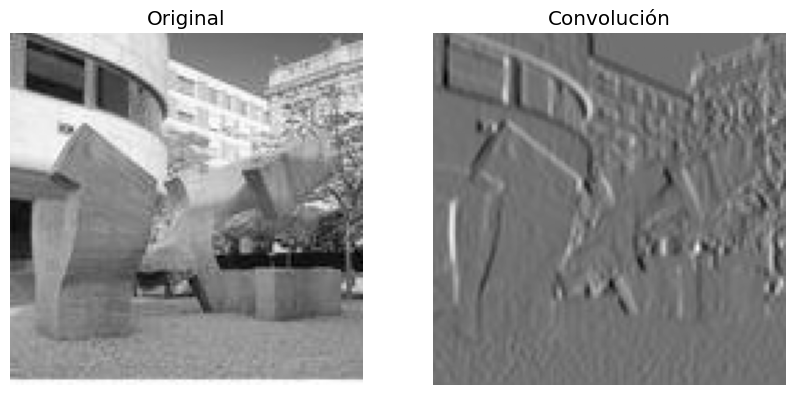

In [123]:
# Convert to numpy array and display
image_path = 'data/'+ train.loc[train.index[0], 'main_image_path']
#example = np.array(Image.open(image_path).convert('L'))

#plt.figure(figsize=(10, 5))
#plt.imshow(example, cmap='gray')
#plt.axis('off')
#plt.show()

# Convertimos la imagen a tensor
example = torch.tensor(np.array(Image.open(image_path).convert('L')), dtype=torch.float32)

# Definimos el kernel para detectar bordes verticales
kernel = torch.tensor([[-1, 0, 1],
                      [-1, 0, 1], 
                      [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Aplicamos la convolución
grad = F.conv2d(example.unsqueeze(0).unsqueeze(0), kernel, padding=0)
grad = grad.squeeze().detach().numpy()

# Mostramos la imagen original y el resultado de la convolución
def plot_two(img_orig, img_conv):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img_orig, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(122) 
    plt.imshow(img_conv, cmap='gray')
    plt.title('Convolución')
    plt.axis('off')
    plt.show()
    
plot_two(example, grad)

En la figura anterior se ha observado como al aplicar sólo un nivel de convolución se comienza definir las lineas y objetos. En el paso siguiente se observará que al aplicar mas niveles mejor definicion es identificada.

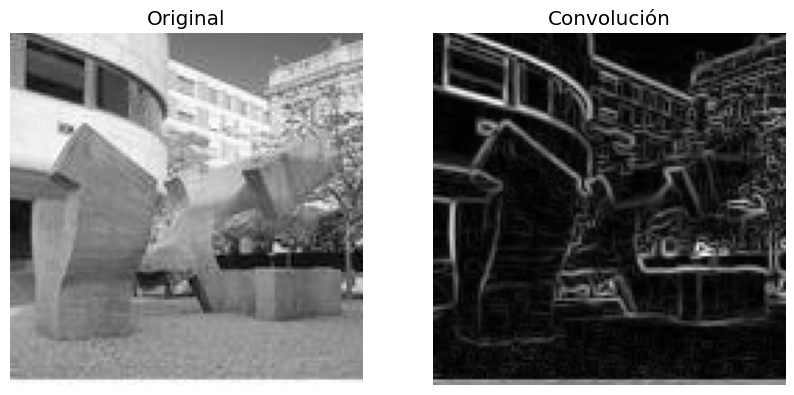

In [ ]:
# Podemos combinar ambos kernels para detectar líneas en ambas direcciones
# Kernel para bordes verticales
kernel_v = torch.tensor([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Kernel para bordes horizontales 
kernel_h = torch.tensor([[-1, -1, -1],
                        [0, 0, 0],
                        [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Aplicamos ambas convoluciones
grad_v = F.conv2d(example.unsqueeze(0).unsqueeze(0), kernel_v, padding=0)
grad_h = F.conv2d(example.unsqueeze(0).unsqueeze(0), kernel_h, padding=0)

# Combinamos los resultados
grad_combined = torch.sqrt(grad_v**2 + grad_h**2)
grad_combined = grad_combined.squeeze().detach().numpy()

plot_two(example, grad_combined)

# Definicion del modelo de CNN

In [ ]:
#


In [125]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)
        return output

def flatChannels(x):
    size = x.size()
    return x.view(size[0],size[1],size[2]*size[3])

def globalAvgPool2D(x):        
    return flatChannels(x).mean(dim=-1)

def globalMaxPool2D(x):
    return flatChannels(x).max(dim=-1)
   
# Red CNN basica
class ConvNet(nn.Module):
    def __init__(self,num_classes=10):
        super(ConvNet,self).__init__()

        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)

        #removed the pool from here to put it in forward
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, 
                                self.unit5, self.unit6, self.unit7, self.pool2, self.unit8, 
                                self.unit9, self.unit10, self.unit11, self.pool3, 
                                self.unit12, self.unit13, self.unit14)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)


    def forward(self, input):
        output = self.net(input)
        output = globalAvgPool2D(output) #or globalMaxPool2D
        output = self.fc(output)
        return output
    
model = ConvNet()

# Contamos el número total de parámetros del modelo
total_params = sum(p.numel() for p in model.parameters())
print(f'Número total de parámetros: {total_params:,}')

# Desglose de parámetros por capa
print('\nDesglose de parámetros por capa:')
for name, param in model.named_parameters():
    print(f'{name}: {param.numel():,} parámetros')

Número total de parámetros: 1,111,818

Desglose de parámetros por capa:
unit1.conv.weight: 864 parámetros
unit1.conv.bias: 32 parámetros
unit1.bn.weight: 32 parámetros
unit1.bn.bias: 32 parámetros
unit2.conv.weight: 9,216 parámetros
unit2.conv.bias: 32 parámetros
unit2.bn.weight: 32 parámetros
unit2.bn.bias: 32 parámetros
unit3.conv.weight: 9,216 parámetros
unit3.conv.bias: 32 parámetros
unit3.bn.weight: 32 parámetros
unit3.bn.bias: 32 parámetros
unit4.conv.weight: 18,432 parámetros
unit4.conv.bias: 64 parámetros
unit4.bn.weight: 64 parámetros
unit4.bn.bias: 64 parámetros
unit5.conv.weight: 36,864 parámetros
unit5.conv.bias: 64 parámetros
unit5.bn.weight: 64 parámetros
unit5.bn.bias: 64 parámetros
unit6.conv.weight: 36,864 parámetros
unit6.conv.bias: 64 parámetros
unit6.bn.weight: 64 parámetros
unit6.bn.bias: 64 parámetros
unit7.conv.weight: 36,864 parámetros
unit7.conv.bias: 64 parámetros
unit7.bn.weight: 64 parámetros
unit7.bn.bias: 64 parámetros
unit8.conv.weight: 73,728 parámetros


In [ ]:
Antes de comen

In [120]:
# Creamos los dataloaders
batch_size = 64
trainloader = DataLoader(train_images_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(validation_images_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_images_dataset, batch_size=batch_size, shuffle=False)



In [121]:
from module_utils import train_epoch, eval_epoch, evaluate_model, plot_training_curves



In [124]:
# Creamos una instancia del modelo
model = ConvNet()

# Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Entrenamos el modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento
num_epochs = 10
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(num_epochs):
    loss, acc = train_epoch(model, device, trainloader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, device, valloader, criterion)
    train_losses.append(loss)
    train_accs.append(acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}, Loss: {loss}, Acc: {acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

# Evaluación
accuracy = evaluate_model(model, testloader, device)
print('Test accuracy: %.3f' % accuracy)

plot_training_curves(train_losses, val_losses, train_accs, val_accs, num_epochs, test_acc=accuracy)

ValueError: too many values to unpack (expected 2)

ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND
ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND

In [ ]:
# Creamos los dataloaders
batch_size = 64
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(validation, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Imprimir tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de validación: {len(validation)}")
print(f"Tamaño del conjunto de test: {len(test)}")

In [ ]:
import os 
print(os.getcwd())
import matplotlib.image as mpimg


for i in range(len(train)):
    image_path = 'Practica_Deep_Learning/codigo/data/' + train.loc[train.index[1], 'main_image_path']
    image = mpimg.imread(image_path) # images are color images
    print(image.shape)
    image.squeeze()
    print(image.shape)

    print(image.dtype)

In [ ]:
import matplotlib.image as mpimg

%matplotlib inline

plt.figure(figsize=(10, 5))

for i in range(5):
    image_path = 'data/' + train.loc[train.index[i], 'main_image_path']

    image = mpimg.imread(image_path) # images are color images
    print(image.shape)
    

    plt.subplot(1, 5, i+1)
    plt.imshow(image)

plt.suptitle('Ejemplos de las imagenes del dataset')
plt.show()

In [12]:
# Construimos la clase donde albergaremos la estructura de autoencoder convolucional
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Primera capa convolucional
            # Input: (batch_size, 1, 28, 28) -> Output: (batch_size, 32, 14, 14)
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.25),
            
            # Segunda capa convolucional
            # Input: (batch_size, 32, 14, 14) -> Output: (batch_size, 64, 7, 7)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.25),
            
            # Tercera capa convolucional
            # Input: (batch_size, 64, 7, 7) -> Output: (batch_size, 128, 4, 4)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            
            # Aplanamos para la capa latente
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Desde el espacio latente
            # Input: (batch_size, latent_dim) -> Output: (batch_size, 512)
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            # Input: (batch_size, 512) -> Output: (batch_size, 128*4*4)
            nn.Linear(512, 128 * 4 * 4),
            nn.LeakyReLU(0.2),
            # Input: (batch_size, 128*4*4) -> Output: (batch_size, 128, 4, 4)
            nn.Unflatten(1, (128, 4, 4)),
            
            # Primera capa deconvolucional
            # Input: (batch_size, 128, 4, 4) -> Output: (batch_size, 64, 7, 7)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.25),
            
            # Segunda capa deconvolucional
            # Input: (batch_size, 64, 7, 7) -> Output: (batch_size, 32, 14, 14)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.25),
            
            # Capa final
            # Input: (batch_size, 32, 14, 14) -> Output: (batch_size, 1, 28, 28)
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Codificamos
        latent = self.encoder(x)
        # Decodificamos
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

In [41]:
train_X = train.drop(columns=['id', 'name', 'shortDescription', 'main_image_path'])
train_X = torch.tensor(train_X.values)

test_X = test.drop(columns=['id', 'name', 'shortDescription', 'main_image_path'])
test_X = torch.tensor(test_X.values)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainX = torch.tensor(train_X).clone().detach().to(device)
testX = torch.tensor(test_X).clone().detach().to(device)

trainX = trainX.float()
testX = testX.float()

train_X.shape

#from torch.utils.data import DataLoader, TensorDataset

#train_loader = DataLoader(TensorDataset(trainX, trainX), batch_size=32, shuffle=True, num_workers=4)
#train_loader.dataset


In [ ]:
from torch.utils.data import DataLoader, TensorDataset



# Inicializamos el número de épocas y bs
EPOCHS = 50  # Aumentamos épocas significativamente
BS = 32  # Reducimos batch size para mejor generalización

# Entrenamos nuestra red Autoencoder convolucional
print("[INFO] training autoencoder...")

# Creamos los dataloaders con num_workers para carga paralela
train_loader = DataLoader(TensorDataset(trainX.unsqueeze(1), trainX.unsqueeze(1)), batch_size=BS, shuffle=True, num_workers=4)
test_loader = DataLoader(TensorDataset(testX.unsqueeze(1), testX.unsqueeze(1)), batch_size=BS, num_workers=4)

# Definimos el modelo, criterio y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
# Calculamos y mostramos el número total de parámetros del modelo
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO] Número total de parámetros del modelo: {total_params:,}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO] Número de parámetros entrenables: {trainable_params:,}")

# Usamos IoU nativo de PyTorch como criterio
criterion = nn.BCELoss()

# Optimizador con mejores hiperparámetros
print(model.parameters())

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5, betas=(0.9, 0.999))

# Learning rate scheduling más agresivo
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=20,  # Ciclo inicial
    T_mult=2,  # Multiplicador para siguientes ciclos
    eta_min=1e-6  # LR mínimo
)

In [ ]:

from module_utils import train_epoch, eval_epoch
from tqdm import tqdm

In [ ]:
# Listas para almacenar las métricas
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')

# Entrenamiento
pbar = tqdm(range(EPOCHS), desc='Training')
for epoch in pbar:
    # Entrenamiento
    train_loss, train_acc, current_lr = train_epoch(
        model=model,
        device=device,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validación
    val_loss, val_acc = eval_epoch(
        model=model,
        device=device,
        val_loader=test_loader,
        criterion=criterion
    )
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    
    # Actualizar la barra de progreso
    pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Val Loss': f'{val_loss:.4f}',
        'LR': f'{current_lr:.6f}'
    })